In [5]:
import numpy as np
from copy import deepcopy
from rdkit import Chem
from rdkit.Chem import BRICS
from CombineMols.CombineMols import CombineMols

import sys
sys.path.append('../molecules')
from conversion import mol_from_smiles, mol_to_smiles
from rdkit.Chem import MolToSmiles, MolFromSmiles

In [3]:

def break_on_bond(mol, bond, min_length=3):
    if mol.GetNumAtoms() - bond <= min_length:
        return [mol]

    broken = Chem.FragmentOnBonds(
        mol, bondIndices=[bond],
        dummyLabels=[(0, 0)])

    res = Chem.GetMolFrags(
        broken, asMols=True, sanitizeFrags=False)

    return res

In [4]:
def fragment_iterative(mol, min_length=3):

    bond_data = list(BRICS.FindBRICSBonds(mol))

    try:
        idxs, labs = zip(*bond_data)
    except Exception:
        return []

    bonds = []
    for a1, a2 in idxs:
        bond = mol.GetBondBetweenAtoms(a1, a2)
        bonds.append(bond.GetIdx())

    order = np.argsort(bonds).tolist()
    bonds = [bonds[i] for i in order]

    frags, temp = [], deepcopy(mol)
    for bond in bonds:
        res = break_on_bond(temp, bond)

        if len(res) == 1:
            frags.append(temp)
            break

        head, tail = res

        frags.append(head)
        temp = deepcopy(tail)

    return frags


In [5]:
def break_into_fragments(mol, smi):
    frags = fragment_iterative(mol)

    if len(frags) == 0:
        return smi, np.nan, 0

    if len(frags) == 1:
        return smi, smi, 1

    return smi, np.nan, 0

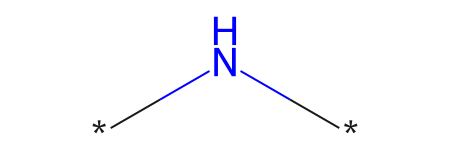

In [39]:

smiles = '*N*'
mol = mol_from_smiles(smiles)
mol

In [17]:
break_into_fragments(mol, smiles)

('CCCOCc1cc(c2ncccc2)ccc1', nan, 0)

In [32]:
fragments = ['*C(CC)B1OC2C3CC(CC2(C)O1)C3(C)C', '*N*', '*c1cnc2n(c1=O)C(C(*)=O)CC2(C)CC(=O)Nc1ccccc1', '*N*', '*C*', '*c1cccc(*)c1', 'C(*)(F)(F)F']

In [33]:
def replace_last(s, old, new):
    s_reversed = s[::-1]
    old_reversed = old[::-1]
    new_reversed = new[::-1]

    # Replace the first occurrence in the reversed string
    s_reversed = s_reversed.replace(old_reversed, new_reversed, 1)

    # Reverse the string back to original order
    return s_reversed[::-1]

In [34]:
def reconstruct(frag_1, frag_2):
    print("Reconstructing...")
    recomb = replace_last(frag_2, "*", frag_1.replace("*","",1))
    #recomb = frag_2.replace("*", frag_1.replace("*","",1),1)
    print(recomb)
    try:
        recomb_canon = MolToSmiles(MolFromSmiles(Chem.CanonSmiles(recomb)),rootedAtAtom = 1)
        #print(recomb_canon)
        print("Reconstruction: ", recomb_canon)
        return recomb_canon
    except:
        print("Reconstruction failed")


Reconstructing...
C(c1cccc(*)c1)(F)(F)F
Reconstruction:  c1(*)cccc(C(F)(F)F)c1


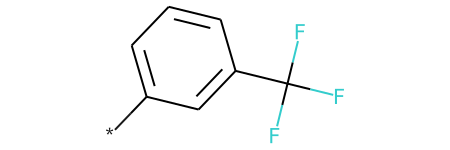

In [39]:
reconstructed = reconstruct(fragments[-2],fragments[-1])
MolFromSmiles(reconstructed)

Reconstructing...
c1(C*)cccc(C(F)(F)F)c1
Reconstruction:  C(*)c1cccc(C(F)(F)F)c1


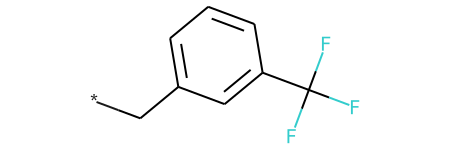

In [40]:
reconstructed = reconstruct(fragments[-3],reconstructed)
MolFromSmiles(reconstructed)

Reconstructing...
C(N*)c1cccc(C(F)(F)F)c1
Reconstruction:  N(*)Cc1cccc(C(F)(F)F)c1


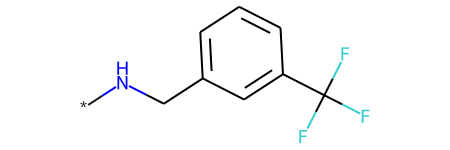

In [41]:
reconstructed = reconstruct(fragments[-4],reconstructed)
MolFromSmiles(reconstructed)

Reconstructing...
N(c1cnc2n(c1=O)C(C(*)=O)CC2(C)CC(=O)Nc1ccccc1)Cc1cccc(C(F)(F)F)c1
Reconstruction:  C(*)(=O)C1CC(C)(CC(=O)Nc2ccccc2)c2ncc(NCc3cccc(C(F)(F)F)c3)c(=O)n21


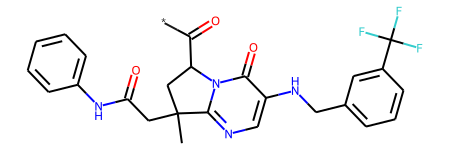

In [42]:
reconstructed = reconstruct(fragments[-5],reconstructed)
MolFromSmiles(reconstructed)

Reconstructing...
C(N*)(=O)C1CC(C)(CC(=O)Nc2ccccc2)c2ncc(NCc3cccc(C(F)(F)F)c3)c(=O)n21
Reconstruction:  N(*)C(=O)C1CC(C)(CC(=O)Nc2ccccc2)c2ncc(NCc3cccc(C(F)(F)F)c3)c(=O)n21


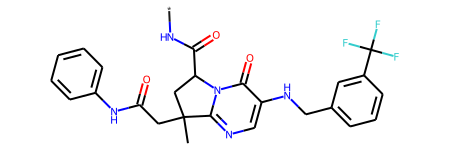

In [43]:
reconstructed = reconstruct(fragments[-6],reconstructed)
MolFromSmiles(reconstructed)

Reconstructing...
N(C(CC)B1OC2C3CC(CC2(C)O1)C3(C)C)C(=O)C1CC(C)(CC(=O)Nc2ccccc2)c2ncc(NCc3cccc(C(F)(F)F)c3)c(=O)n21
Reconstruction:  C(C)C(NC(=O)C1CC(C)(CC(=O)Nc2ccccc2)c2ncc(NCc3cccc(C(F)(F)F)c3)c(=O)n21)B1OC2C3CC(CC2(C)O1)C3(C)C


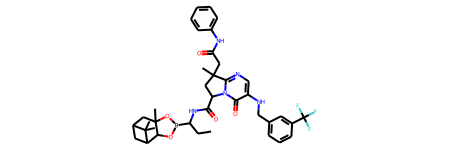

In [44]:
reconstructed = reconstruct(fragments[-7],reconstructed)
MolFromSmiles(reconstructed)

CCC(NC(=O)C1CC(C)(CC(=O)Nc2ccccc2)c2ncc(NCc3cccc(C(F)(F)F)c3)c(=O)n21)B1OC2C3CC(CC2(C)O1)C3(C)C


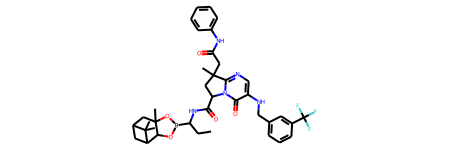

In [46]:
mol_canon = Chem.CanonSmiles('CCC(NC(=O)C1CC(C)(CC(=O)Nc2ccccc2)c2ncc(NCc3cccc(C(F)(F)F)c3)c(=O)n21)B1OC2C3CC(CC2(C)O1)C3(C)C')
print(mol_canon)
MolFromSmiles(mol_canon)

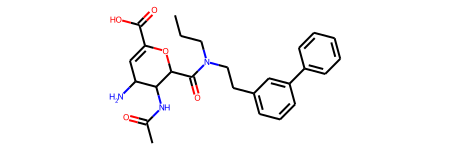

In [64]:
MolFromSmiles(Chem.CanonSmiles('CCCN(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O'))

In [52]:
Chem.CanonSmiles("Oc1cccc(C(C(=O)NC2CCCC2)N(C(=O)c2ccco2)c2ccccc2F)c1OC")

'COc1c(O)cccc1C(C(=O)NC1CCCC1)N(C(=O)c1ccco1)c1ccccc1F'

c1(CC*)cccc(-c2ccccc2)c1
c1(CC*)cccc(-c2ccccc2)c1


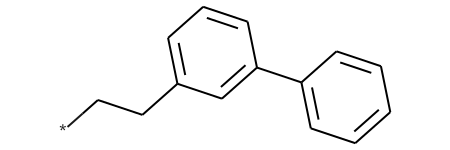

In [72]:
replaced = replace_last(fragments[-1], "*", fragments[-2].replace("*","",1))
print(replaced)
replaced = MolToSmiles(MolFromSmiles(replaced), rootedAtAtom=0)
print(replaced)
MolFromSmiles(replaced)

c1(CCN(*)*)cccc(-c2ccccc2)c1
c1(CCN(*)*)cccc(-c2ccccc2)c1


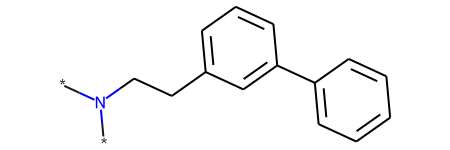

In [73]:
replaced = replace_last(replaced, "*", fragments[-3].replace("*","",1))
print(replaced)
replaced = MolToSmiles(MolFromSmiles(replaced), rootedAtAtom=0)
print(replaced)
MolFromSmiles(replaced)

c1(CCN(*)C(*)=O)cccc(-c2ccccc2)c1
c1(CCN(*)C(*)=O)cccc(-c2ccccc2)c1


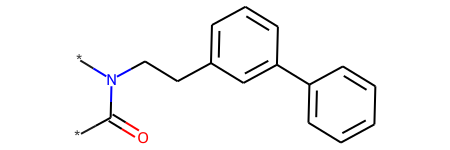

In [74]:
replaced = replace_last(replaced, "*", fragments[-4].replace("*","",1))
print(replaced)
replaced = MolToSmiles(MolFromSmiles(replaced), rootedAtAtom=0)
print(replaced)
MolFromSmiles(replaced)

c1(CCN(*)C(C1OC(C(=O)O)=CC(N)C1*)=O)cccc(-c2ccccc2)c1
C12=CC=CC(c3ccccc3)=CC(*)C(N)C=C(C(=O)O)OC1C(=O)N(*)CC2


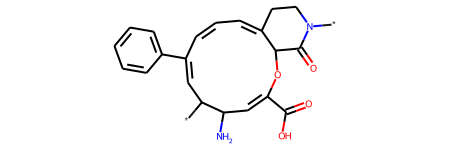

In [75]:
replaced = replace_last(replaced, "*", fragments[-5].replace("*","",1))
print(replaced)
replaced = MolToSmiles(MolFromSmiles(replaced), rootedAtAtom=0)
print(replaced)
MolFromSmiles(replaced)

*CCN(*)C1OC(C(=O)O)=CC(N)C1NC(C)=O
*CCN(*)C1OC(C(=O)O)=CC(N)C1NC(C)=O


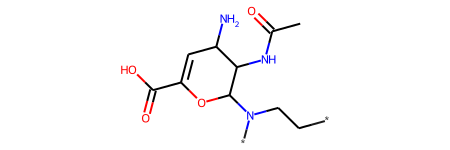

In [92]:
replaced = replace_last(fragments[-6], "*", replaced.replace("*","",1))
print(replaced)
replaced = Chem.CanonSmiles(MolToSmiles(MolFromSmiles(replaced), rootedAtAtom=0))
print(replaced)
MolFromSmiles(replaced)

*c1cccc(CCN(*)C1OC(C(=O)O)=CC(N)C1NC(C)=O)c1
*C1=CC=CC2=CC(NC(C)=O)C(N)C=C(C(=O)O)OC1N(*)CC2


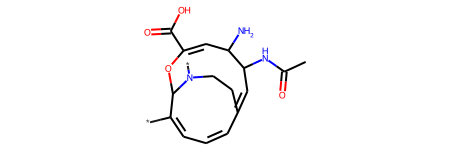

In [93]:
replaced = replace_last(fragments[-7], "*", replaced.replace("*","",1))
print(replaced)
replaced = Chem.CanonSmiles(MolToSmiles(MolFromSmiles(replaced), rootedAtAtom=0))
print(replaced)
MolFromSmiles(replaced)

In [154]:
replaced = replace_last(fragments[-8], "(*)", replace_last(replaced,"(*)",""))
print(replaced)
replaced = MolToSmiles(MolFromSmiles(replaced), rootedAtAtom=0)
print(replaced)
MolFromSmiles(replaced)

c1c1(*)ccccCCNC(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=Oc1ccccc1


[16:36:09] SMILES Parse Error: ring closure 1 duplicates bond between atom 0 and atom 1 for input: 'c1c1(*)ccccCCNC(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=Oc1ccccc1'


ArgumentError: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType)
did not match C++ signature:
    MolToSmiles(class RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(class RDKit::ROMol mol, struct RDKit::SmilesWriteParams params)

CCC*
CCC*


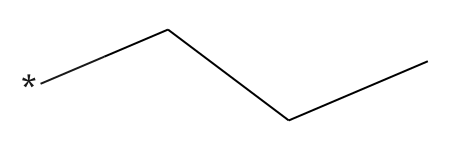

In [155]:
replaced = replace_last(fragments[-9], "(*)", replace_last(replaced,"(*)",""))
print(replaced)
replaced = MolToSmiles(MolFromSmiles(replaced), rootedAtAtom=0)
print(replaced)
MolFromSmiles(replaced)

N(*)(CC*)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O


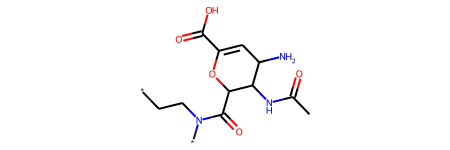

In [138]:
MolFromSmiles("N(*)(CC*)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O")
print(MolToSmiles(MolFromSmiles("N(*)(CC*)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O"), rootedAtAtom=0))
MolFromSmiles("N(*)(CC*)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O")

C(*)CN(*)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O


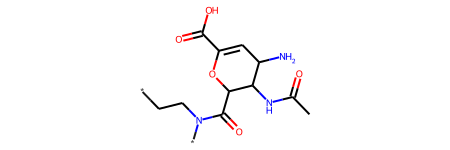

In [146]:
MolFromSmiles("C(*)CN(*)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O")
print(MolToSmiles(MolFromSmiles("C(*)CN(*)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O"), rootedAtAtom=0))
MolFromSmiles("C(*)CN(*)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O")

In [36]:
MolToSmiles(CombineMols(MolFromSmiles("Ic1ccccc1"),MolFromSmiles("Ic1cccc(CCN(I)C(=O)C2OC(C(=O)O)=CC(N)C2NC(C)=O)c1"), "I")[0], rootedAtAtom=0)


'c1(C2:ccccc:2)cccc(CCN(I)C(=O)C2OC(C(=O)O)=CC(N)C2NC(C)=O)c1'

In [29]:
MolToSmiles(CombineMols(MolFromSmiles("N(I)(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O"),MolFromSmiles("CCCI"), "I")[0])


'CCCN(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O'

In [57]:
frag_1 = "c1(*)ccccc1"
frag_2 = "N(*)(CCc1cccc(*)c1)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O"

In [58]:
replaced = replace_last(fragments[-9], "(*)", replace_last(replaced,"(*)",""))
print(replaced)
replaced = MolToSmiles(MolFromSmiles(replaced), rootedAtAtom=0)
print(replaced)
MolFromSmiles(replaced)

c1c1cccc(CCN(*)C(=O)C2OC(C(=O)O)=CC(N)C2NC(C)=O)c1ccccc1


ArgumentError: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType)
did not match C++ signature:
    MolToSmiles(class RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(class RDKit::ROMol mol, struct RDKit::SmilesWriteParams params)

In [67]:
frag_1 = MolToSmiles(MolFromSmiles("N(*)(CCc1cccc(*)c1)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O"), rootedAtAtom=9)
frag_2 = MolToSmiles(MolFromSmiles("c1(*)ccccc1"), rootedAtAtom=1)
print(frag_1)
print(frag_2)

*c1cccc(CCN(*)C(=O)C2OC(C(=O)O)=CC(N)C2NC(C)=O)c1
*c1ccccc1


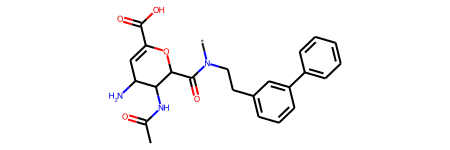

In [4]:
MolFromSmiles("N(*)(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O")

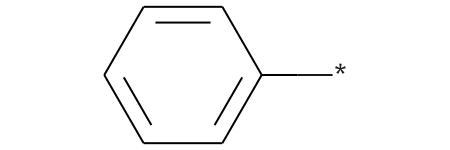

In [145]:
MolFromSmiles("c1cccc(*)c1")

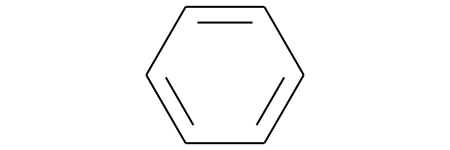

In [146]:
MolFromSmiles("c1ccccc1")


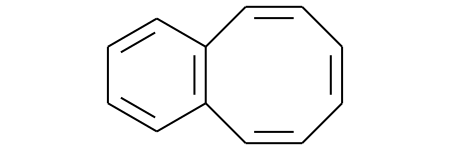

In [147]:
MolFromSmiles("c1cccc(c1ccccc1)c1")

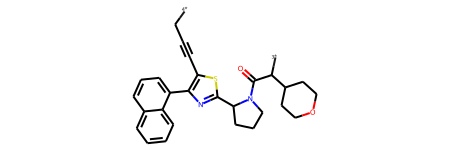

In [31]:
MolFromSmiles("C([3*])(C(=O)N1CCCC1c1nc(-c2cccc3ccccc23)c(C#CC[4*])s1)C1CCOCC1")

In [17]:
MolToSmiles(MolFromSmiles("N(*)(CCc1cccc(c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O"), rootedAtAtom=10)

'c1ccccc1-c1cccc(CCN(*)C(=O)C2OC(C(=O)O)=CC(N)C2NC(C)=O)c1'

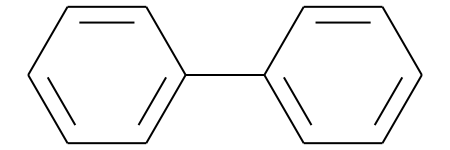

In [23]:
CombineMols(MolFromSmiles("c1cccc(I)c1"),MolFromSmiles("Ic1ccccc1"), "I")[0]